In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
from dataloader import read_bci_data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Load data
train_data, train_label, test_data, test_label = read_bci_data()

# Convert data type into float32
train_data  = torch.from_numpy(train_data).type(torch.float32)
train_label = torch.from_numpy(train_label).type(torch.long)
test_data   = torch.from_numpy(test_data).type(torch.float32)
test_label  = torch.from_numpy(test_label).type(torch.long)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


## Implement EEGNet

In [4]:
class EEGNet(nn.Sequential):
    def __init__(self):
        ### Layer 1
        firstconv = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=(1,51),stride=(1,1), padding=(0,25), bias=False),
            nn.BatchNorm2d(16)
        )
        
        ### Layer 2
        depthwiseConv = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(2,1),stride=(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(alpha=0.1),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout2d(p = 0.25)
        )
        
        ### Layer 3
        seperableConv = nn.Sequential(
            nn.Conv2d(32,32,kernel_size=(1,15),stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(alpha=0.1),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout2d(p = 0.25),
            nn.Flatten()
        )
        
        ### Fully connected layer
        classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        super(EEGNet, self).__init__(OrderedDict([
                  ('firstconv'    , firstconv),
                  ('depthwiseConv', depthwiseConv),
                  ('seperableConv', seperableConv),
                  ('classify'     , classify)
                ]))
        
    def forward(self,x):
        x = super(EEGNet,self).forward(x)
        return x
    
    def infer_and_cal_acc(self,x,ground_truth):
        # Run self.forward(x) and calculate accuracy with ground_truth
        
        y = self.forward(x)
        # Get the calssification result of y,
        # because y has 2 channels for each class
        _, y_hat = torch.max(y,1)
        # Calculate accuracy
        acc = 100*(len(ground_truth[ground_truth==y_hat])/len(ground_truth))
        return acc
        

In [5]:
net = EEGNet().to(device)

In [6]:
net.parameters

<bound method Module.parameters of EEGNet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=0.1)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (seperableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=0.1)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Flatten()
  )
  (classify): Sequential(
    (0): Linear(in_featu

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [8]:
train_data.shape[0]

1080

In [9]:
num_epochs = 300
batch_size = 80
print_freq = 20
train_data = train_data.to(device)
train_label = train_label.to(device)
test_data = test_data.to(device)
test_label = test_label.to(device)


loss_list = []
acc_train_list = []
acc_test_list = []
for epoch in range(1,num_epochs+1):
    # Loss in an epoch
    epoch_loss = 0.0
    
    # Make train_data run in batch
    permutation = torch.randperm(train_data.shape[0])
    
    for i in range(0,train_data.shape[0], batch_size):
        # Zero the gradients
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = train_data[indices], train_label[indices]
        
        # Run the net & Update
        outputs = net(batch_x)
        #print('output = ',outputs)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Calclate accuracy
    acc_train_list.append(net.infer_and_cal_acc(train_data,train_label))
    acc_test_list.append(net.infer_and_cal_acc(test_data,test_label))
    
    
    loss_list.append(epoch_loss)
    if epoch % print_freq == 0:
        print('epoch ',epoch,' : loss = ',epoch_loss)

epoch  20  : loss =  5.030472666025162
epoch  40  : loss =  3.691017806529999
epoch  60  : loss =  2.497173860669136
epoch  80  : loss =  1.9178781658411026
epoch  100  : loss =  1.436112117022276
epoch  120  : loss =  1.4226522631943226
epoch  140  : loss =  0.9299935437738895
epoch  160  : loss =  0.7457759045064449
epoch  180  : loss =  0.7228838670998812
epoch  200  : loss =  0.8527381177991629
epoch  220  : loss =  0.5237102508544922
epoch  240  : loss =  0.5666911844164133
epoch  260  : loss =  0.4696799786761403
epoch  280  : loss =  0.5045978166162968
epoch  300  : loss =  0.5740586733445525


In [10]:
import matplotlib.pyplot as plt

def drow_figure(x):
    plt.plot(range(len(x)), x)
    plt.show()

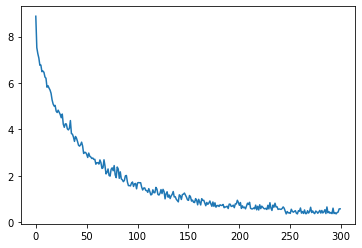

In [11]:
drow_figure(loss_list)

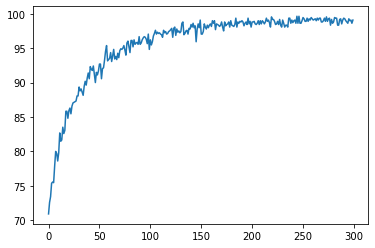

In [12]:
drow_figure(acc_train_list)

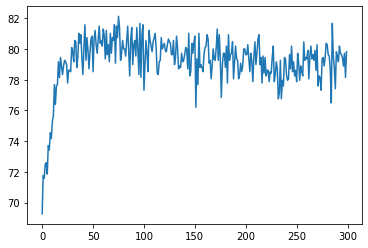

In [13]:
drow_figure(acc_test_list)